In [1]:
##################################################################################################################################
#                                                                                                                                #
#                             An Explainable AI Framework for Satellite Network Anomaly Detection                                #
#                                                                                                                                #
#                                                                                                                                #
#                                        *******   Jamming / Interference  *******                                               #
#                                                                                                                                #
#                                                                                                                                #
#                                                    University of Hull                                                          #
#                                                MSc Artificial Intelligence                                                     #
#                                                                                                                                #
#                                                      Amadiz Sabino                                                             #
#                                                                                                                                #
##################################################################################################################################

In [1]:
# ============================================
# 0. Setup and Imports
# ============================================
# In this notebook we:
# - Load SES ground modem/antenna data
# - Engineer communication features (10-min stats)
# - Train an unsupervised anomaly detector (Isolation Forest)
# - Identify potential jamming / external interference candidates
# - Use a SHAP-based surrogate model to explain anomaly scores

import os
import numpy as np
import pandas as pd
from google.colab import drive

from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Install SHAP for explainability
!pip install shap -q
import shap

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (10, 4)



In [2]:
# ============================================
# 1. Mount Google Drive & Define Paths
# ============================================

# Mounting Drive to access SES files stored in your Google Drive
drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses"
print("DATA_DIR:", DATA_DIR)
!ls "$DATA_DIR"

# Input SES ground data file
SES_GROUND_FILE = os.path.join(DATA_DIR, "SESGroundData_Oct-Nov_AS1.xlsx")

# Creating Output files
COMM_FEATURES_FILE = os.path.join(DATA_DIR, "ses_comm_features.csv")
COMM_ANOMALIES_FILE = os.path.join(DATA_DIR, "ses_comm_anomalies.csv")


Mounted at /content/drive
DATA_DIR: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses
 3_3_SES_Jamming_Interference.ipynb
' 3_3_SES_Prototype_BeamHandover.ipynb'
 3_3_SES_Prototype_SignalLoss.ipynb
 3_3_SES_Prototype_SLA_Proxy.ipynb
 3_3_SES_Space_Weather.ipynb
 Archive
 artifacts_handover
 artifacts_powerfault
 artifacts_signal_loss
 artifacts_sla
 AttitudePIDs.csv
 CIEL2_ManeuverEvents_R1.csv
 gfz_kp_ap_2012-01-01_2020-02-27.csv
 gfz_kp_ap_2023.csv
 LabelManeuverEvents.m
 phase3_ESA-Mission1
 Remove__3_3_SES_Space_Weather_v2.ipynb
 Removed___3_3_SES_Prototype_PowerLoss.ipynb
 ses_clean_10s.parquet
 ses_comm_anomalies.csv
 ses_comm_features.csv
 SESGroundData_Oct-Nov_AS1.xlsx
 ses_maneuver_features.csv
 ses_spaceweather_dataset.csv
 space_weather_gfz_kp_ap_2023_v1.csv
 ThrusterTemperaturePIDs.csv


In [3]:

# ============================================
# 2. Loading SES Ground Data (Oct–Nov) and Select Comm Columns
# ============================================

# Loading the raw SES ground dataset.
df_raw = pd.read_excel(SES_GROUND_FILE)

print("Raw data shape:", df_raw.shape)
print("Columns (first 50):", df_raw.columns[:50].tolist())

# Setting:
# - '_time' - timestamp column
# - Communication-related channels start with 'MODEM__' or 'ANT_'
time_col = "_time"

comm_cols = [
    c for c in df_raw.columns
    if c.startswith("MODEM__") or c.startswith("ANT_")
]

print(f"Number of comm-related columns: {len(comm_cols)}")
print("Example comm-related columns:", comm_cols[:10])

# Keeping only time + communication columns
df = df_raw[[time_col] + comm_cols].copy()

# Parsinge timestamps and setting them as index
df[time_col] = pd.to_datetime(df[time_col])
df = df.sort_values(time_col).set_index(time_col)

print("Data head after selecting comm columns:")
print(df.head())


Raw data shape: (377489, 46)
Columns (first 50): ['_time', 'ANT_1_ACU', 'ANT_2_ACU', 'ANT_3_ACU', 'ANT_4_ACU', 'MODEM__10_IN', 'MODEM__10_OUT', 'MODEM__11_IN', 'MODEM__11_OUT', 'MODEM__14_IN', 'MODEM__14_OUT', 'MODEM__16_IN', 'MODEM__16_OUT', 'MODEM__22_IN', 'MODEM__22_OUT', 'MODEM__23_IN', 'MODEM__23_OUT', 'MODEM__24_IN', 'MODEM__24_OUT', 'MODEM__25_IN', 'MODEM__25_OUT', 'MODEM__26_IN', 'MODEM__26_OUT', 'MODEM__27_IN', 'MODEM__27_OUT', 'MODEM__28_IN', 'MODEM__28_OUT', 'MODEM__32_IN', 'MODEM__32_OUT', 'MODEM__33_IN', 'MODEM__33_OUT', 'MODEM__34_IN', 'MODEM__34_OUT', 'MODEM__37_IN', 'MODEM__37_OUT', 'MODEM__3_IN', 'MODEM__3_OUT', 'MODEM__4_IN', 'MODEM__4_OUT', 'MODEM__5_IN', 'MODEM__5_OUT', 'MODEM__8_IN', 'MODEM__8_OUT', 'MODEM__9_IN', 'MODEM__9_OUT', 'Spacecraft']
Number of comm-related columns: 44
Example comm-related columns: ['ANT_1_ACU', 'ANT_2_ACU', 'ANT_3_ACU', 'ANT_4_ACU', 'MODEM__10_IN', 'MODEM__10_OUT', 'MODEM__11_IN', 'MODEM__11_OUT', 'MODEM__14_IN', 'MODEM__14_OUT']
Data hea

In [5]:

# ============================================
# 3. Preprocessing and Feature Engineering
# ============================================

# Goal: Build features per 10-minute interval that summarize modem/antenna behaviour.
# This stabilizes noise and makes anomaly detection more robust.

# 3.1 Resample to a 10-minute grid and compute basic statistics for each channel
resample_rule = "10min"  # 10 minutes

df_resampled = df.resample(resample_rule).agg(["mean", "std", "min", "max"])

# Flatten MultiIndex columns:
# e.g., ('MODEM__10_IN', 'mean') -> 'MODEM__10_IN_mean'
df_resampled.columns = [
    f"{col}_{stat}"
    for col, stat in df_resampled.columns.to_flat_index()
]

print("Resampled feature shape:", df_resampled.shape)
print("Resampled columns (first 20):", df_resampled.columns[:20].tolist())

# 3.2 Dropping intervals where ALL features are NaN
df_resampled = df_resampled.dropna(how="all")

# 3.3 Handling missing values using:
# - Forward-fill
# - Backward-fill
# - Remaining NaNs to 0
df_resampled = df_resampled.ffill().bfill().fillna(0)

print("Resampled & cleaned head:")
print(df_resampled.head())

# Maintaining a copy with an explicit time column for saving and later steps
df_features = df_resampled.copy()
df_features["time"] = df_features.index


Resampled feature shape: (6292, 176)
Resampled columns (first 20): ['ANT_1_ACU_mean', 'ANT_1_ACU_std', 'ANT_1_ACU_min', 'ANT_1_ACU_max', 'ANT_2_ACU_mean', 'ANT_2_ACU_std', 'ANT_2_ACU_min', 'ANT_2_ACU_max', 'ANT_3_ACU_mean', 'ANT_3_ACU_std', 'ANT_3_ACU_min', 'ANT_3_ACU_max', 'ANT_4_ACU_mean', 'ANT_4_ACU_std', 'ANT_4_ACU_min', 'ANT_4_ACU_max', 'MODEM__10_IN_mean', 'MODEM__10_IN_std', 'MODEM__10_IN_min', 'MODEM__10_IN_max']
Resampled & cleaned head:
                           ANT_1_ACU_mean  ANT_1_ACU_std  ANT_1_ACU_min  \
_time                                                                     
2021-10-18 07:20:00+00:00       17.260165       3.146179         0.3967   
2021-10-18 07:30:00+00:00       17.260165       3.146179         0.3967   
2021-10-18 07:40:00+00:00       18.133319       0.188440        17.6361   
2021-10-18 07:50:00+00:00       18.495629       0.466238        17.9382   
2021-10-18 08:00:00+00:00       18.661626       0.213157        18.3441   

                       

In [6]:

# ============================================
# 4. Unsupervised Anomaly Detection with Isolation Forest
# ============================================

# 4.1 Preparig the feature matrix (excluding the time column)
feature_cols = [c for c in df_features.columns if c != "time"]
X = df_features[feature_cols].values

# 4.2 Standardizing the features (important for distance-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4.3 Fit Isolation Forest
# This model learns what "normal" communication looks like and flags outliers.
contamination = 0.01  # assumming ~1% of intervals are anomalous (tunable)

iso = IsolationForest(
    n_estimators=200,
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)
iso.fit(X_scaled)

# 4.4 Compute anomaly scores
# decision_function: higher = more normal, lower = more anomalous
# Invertting it so: higher anomaly_score = more anomalous
anomaly_scores = -iso.decision_function(X_scaled)

df_features["anomaly_score"] = anomaly_scores

# 4.5 Defining anomalies using a threshold (e.g. 99th percentile of anomaly_score)
threshold = np.quantile(anomaly_scores, 0.99)
df_features["is_anomaly"] = (df_features["anomaly_score"] >= threshold).astype(int)

print("Anomaly score stats:")
print(df_features["anomaly_score"].describe())
print("Number of detected anomalies:", df_features["is_anomaly"].sum())


Anomaly score stats:
count    6292.000000
mean       -0.109950
std         0.031695
min        -0.168047
25%        -0.131618
50%        -0.115374
75%        -0.093386
max         0.237497
Name: anomaly_score, dtype: float64
Number of detected anomalies: 63


Top 10 anomalies (potential jamming / external interference candidates):
                                               time  anomaly_score
_time                                                             
2021-10-27 02:40:00+00:00 2021-10-27 02:40:00+00:00       0.237497
2021-10-27 02:50:00+00:00 2021-10-27 02:50:00+00:00       0.221208
2021-10-27 02:30:00+00:00 2021-10-27 02:30:00+00:00       0.202587
2021-10-27 00:20:00+00:00 2021-10-27 00:20:00+00:00       0.159740
2021-10-26 23:50:00+00:00 2021-10-26 23:50:00+00:00       0.156267
2021-10-26 22:00:00+00:00 2021-10-26 22:00:00+00:00       0.146220
2021-10-26 21:40:00+00:00 2021-10-26 21:40:00+00:00       0.144950
2021-10-26 21:50:00+00:00 2021-10-26 21:50:00+00:00       0.136616
2021-10-26 23:40:00+00:00 2021-10-26 23:40:00+00:00       0.134072
2021-10-26 23:20:00+00:00 2021-10-26 23:20:00+00:00       0.132933


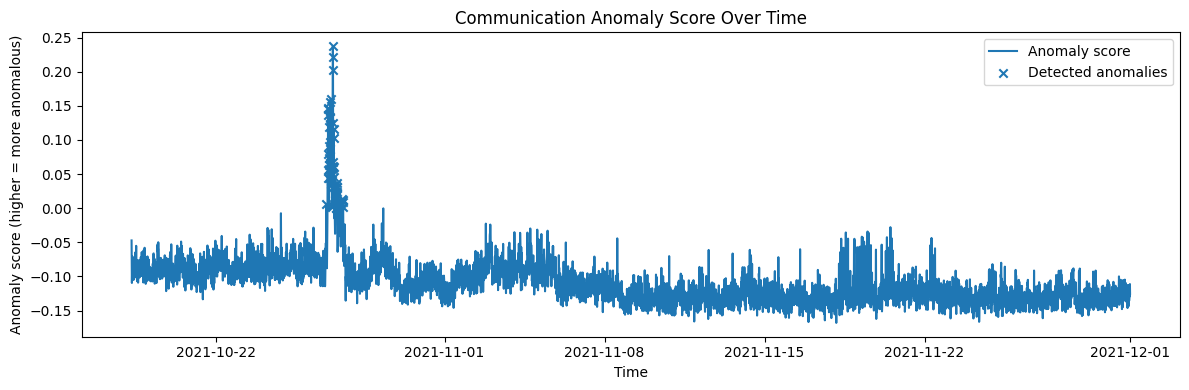

Full comm features (with scores/flags) saved to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/ses_comm_features.csv
Anomalous intervals saved to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/ses_comm_anomalies.csv


In [7]:

# ============================================
# 5. Inspecting and Saving Results (Potential Jamming / Interference Candidates)
# ============================================

# 5.1 Extracting and sorting the most anomalous intervals
df_anomalies = df_features[df_features["is_anomaly"] == 1].copy()
df_anomalies = df_anomalies.sort_values("anomaly_score", ascending=False)

print("Top 10 anomalies (potential jamming / external interference candidates):")
print(df_anomalies[["time", "anomaly_score"]].head(10))

# 5.2 Plot anomaly score over time and highlight anomalies
plt.figure(figsize=(12, 4))
plt.plot(df_features["time"], df_features["anomaly_score"], label="Anomaly score")
plt.scatter(
    df_anomalies["time"],
    df_anomalies["anomaly_score"],
    marker="x",
    label="Detected anomalies"
)
plt.xlabel("Time")
plt.ylabel("Anomaly score (higher = more anomalous)")
plt.title("Communication Anomaly Score Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# 5.3 Feature importances from the Isolation Forest
# Indication of which features are often used to isolate anomalies.
# IsolationForest does not directly expose feature_importances_ like other tree-based models.
# We will rely on SHAP for feature explanations in the next section.

# 5.4 Saving full table and anomaly table to CSV
df_features.to_csv(COMM_FEATURES_FILE, index=False)
df_anomalies.to_csv(COMM_ANOMALIES_FILE, index=False)

print("Full comm features (with scores/flags) saved to:", COMM_FEATURES_FILE)
print("Anomalous intervals saved to:", COMM_ANOMALIES_FILE)


Surrogate model R^2 on test set: 0.8837889384980475
Plotting SHAP summary (global feature importance for anomaly_score)...


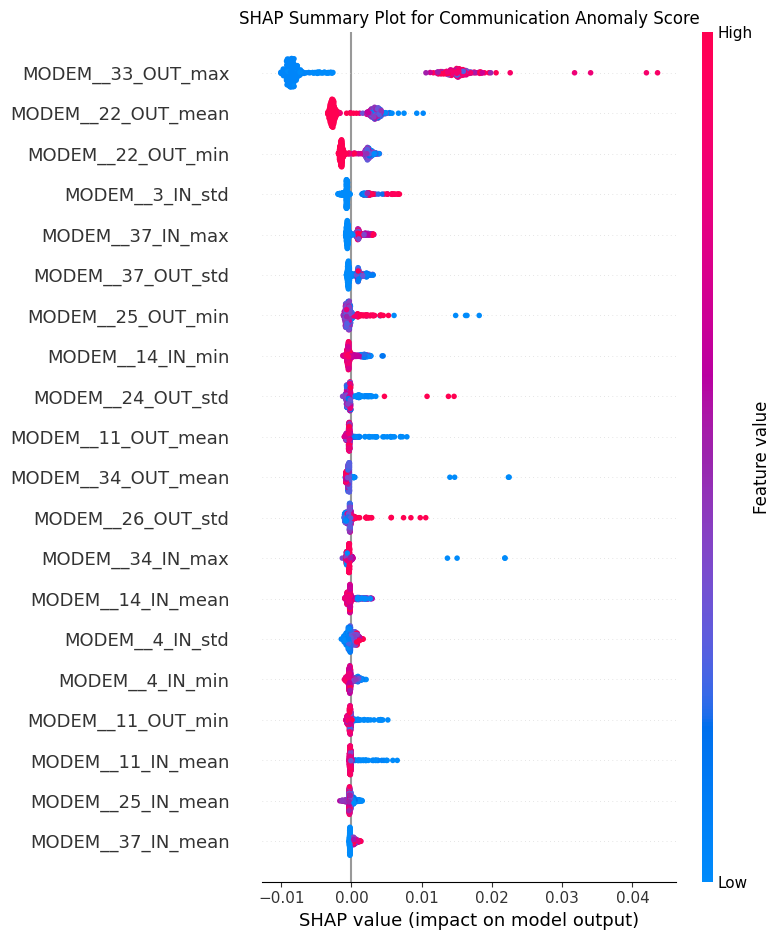


Explaining top 5 potential jamming / external interference candidates:

=== Potential interference candidate 1 ===
Time: 2021-10-27 02:40:00+00:00
Anomaly score: 0.2374971769348769


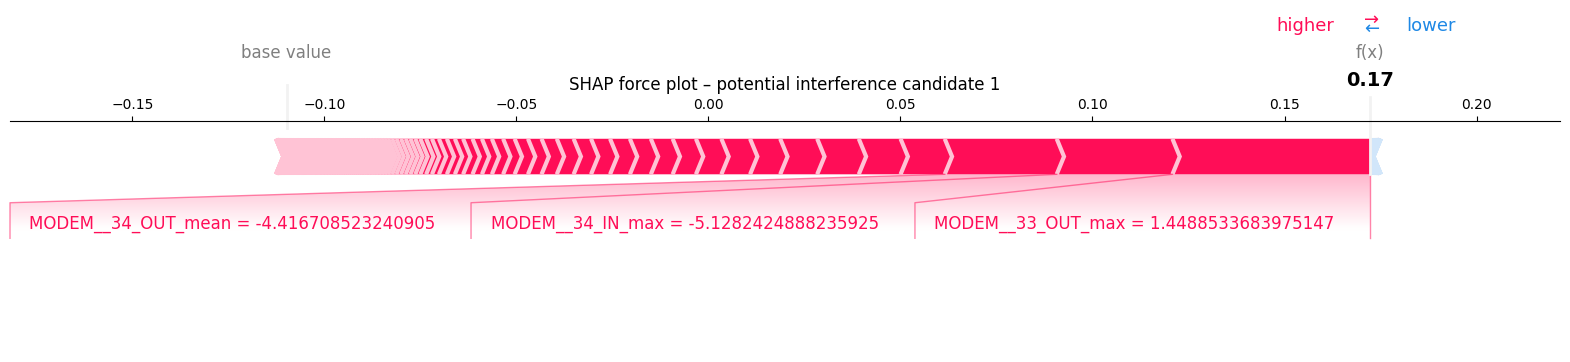


=== Potential interference candidate 2 ===
Time: 2021-10-27 02:50:00+00:00
Anomaly score: 0.2212080314047466


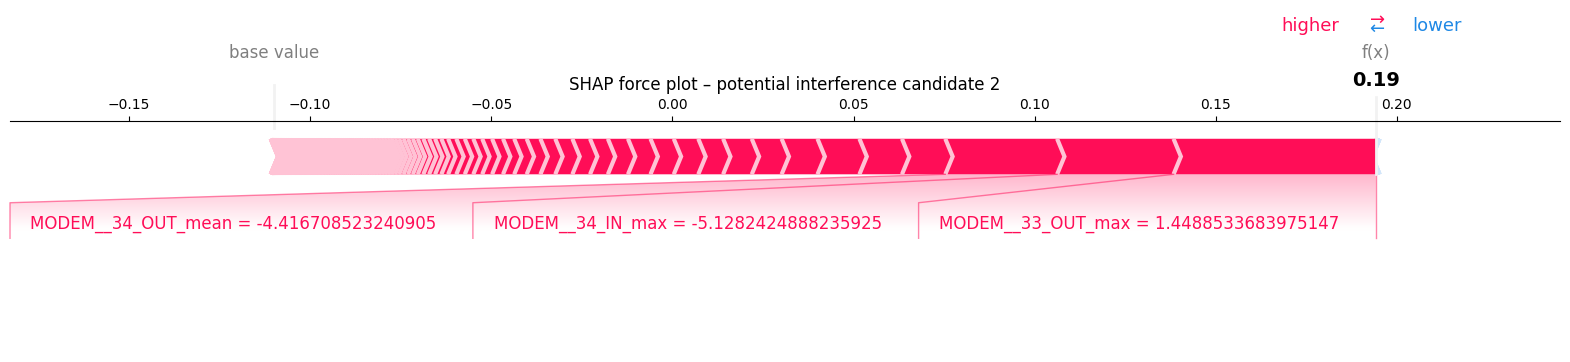


=== Potential interference candidate 3 ===
Time: 2021-10-27 02:30:00+00:00
Anomaly score: 0.20258714779716


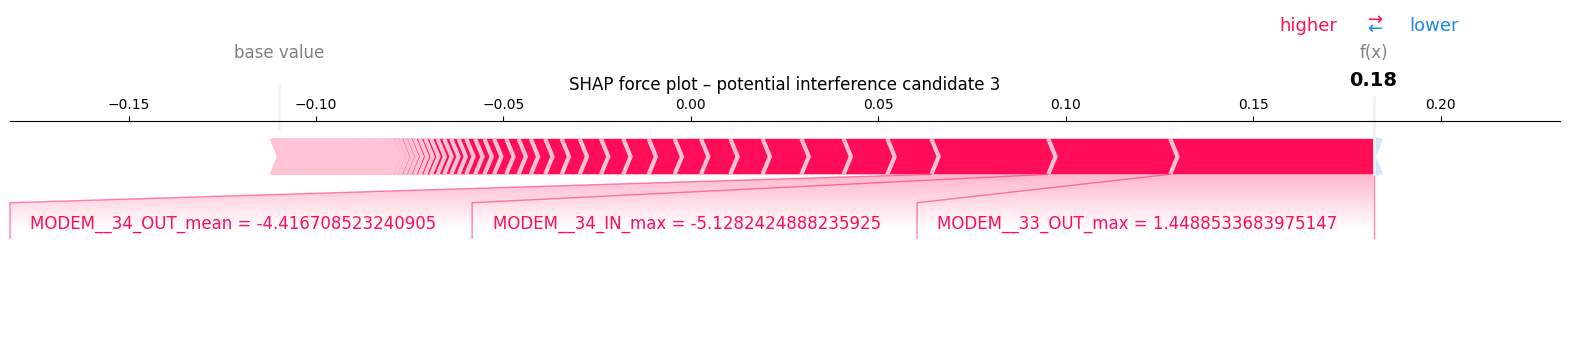


=== Potential interference candidate 4 ===
Time: 2021-10-27 00:20:00+00:00
Anomaly score: 0.1597396205536456


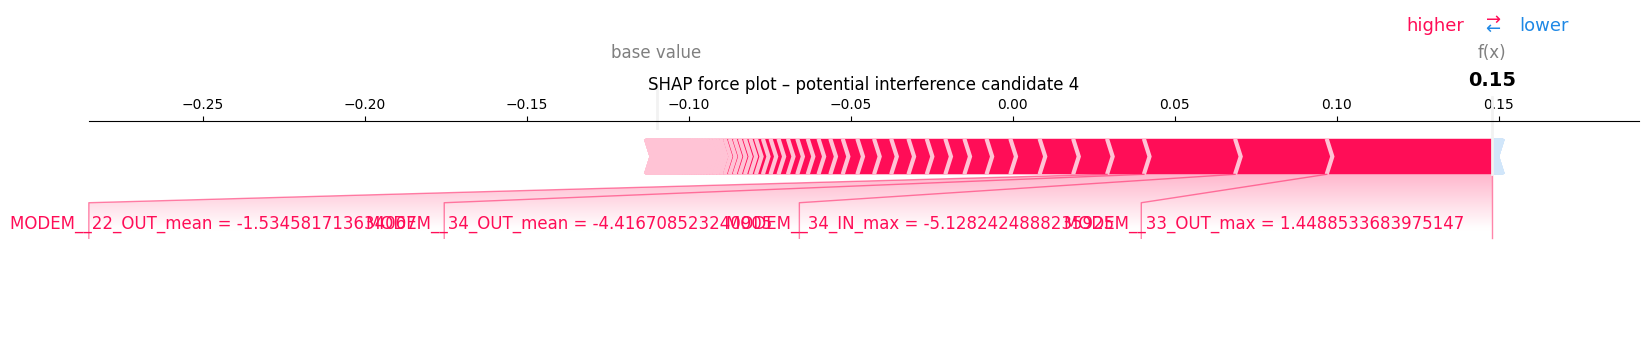


=== Potential interference candidate 5 ===
Time: 2021-10-26 23:50:00+00:00
Anomaly score: 0.1562665696901473


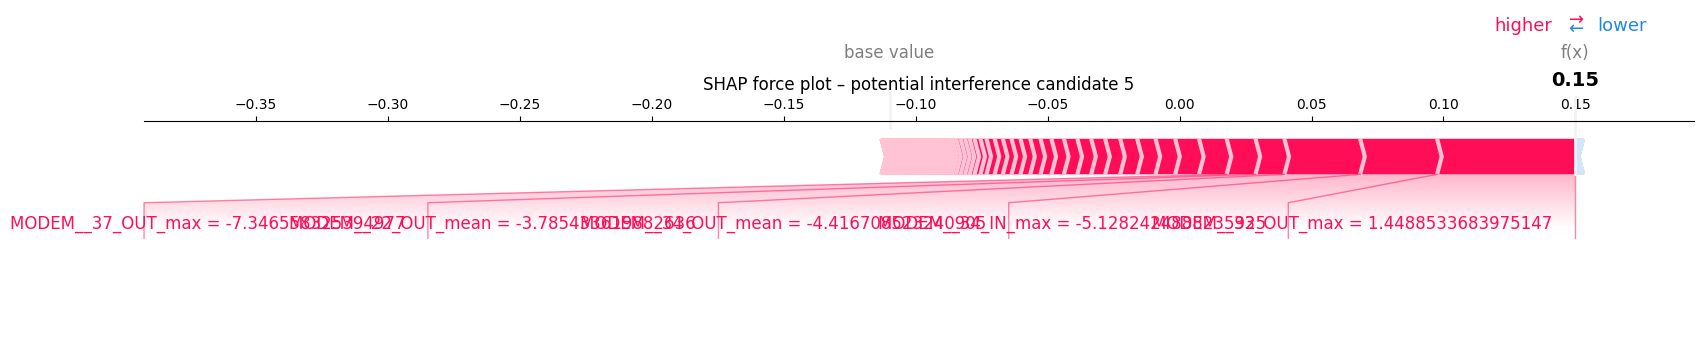

In [8]:

# ============================================
# 6. XAI with SHAP: Explaining Potential Jamming / Interference
# ============================================

# This step is:
# - Treating the Isolation Forest's anomaly_score as a target
# - Training a Random Forest Regressor to approximate that score (surrogate model)
# - Using SHAP on the surrogate to explain which features drive anomaly scores
# - Inspecting SHAP explanations for the top "potential interference" intervals

# 6.1 Reloading features from disk
df_features = pd.read_csv(COMM_FEATURES_FILE, parse_dates=["time"])

feature_cols = [
    c for c in df_features.columns
    if c not in ["time", "anomaly_score", "is_anomaly"]
]
X = df_features[feature_cols].values
y_score = df_features["anomaly_score"].values

# 6.2 Standardizing again for the surrogate model
scaler_sur = StandardScaler()
X_scaled_sur = scaler_sur.fit_transform(X)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_scaled_sur, y_score, test_size=0.2, random_state=42
)

# 6.3 Training Random Forest Regressor as surrogate for anomaly_score
rf_surrogate = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_surrogate.fit(X_train_s, y_train_s)

print("Surrogate model R^2 on test set:", rf_surrogate.score(X_test_s, y_test_s))

# 6.4 Global SHAP explanation: which features drive anomaly scores overall?
explainer = shap.TreeExplainer(rf_surrogate)

# Use a subsample for efficiency
n_sample = min(500, len(X_scaled_sur))
sample_idx = np.random.RandomState(42).choice(len(X_scaled_sur), size=n_sample, replace=False)
X_sample = X_scaled_sur[sample_idx]
X_sample_df = pd.DataFrame(X_sample, columns=feature_cols)

shap_values = explainer.shap_values(X_sample)

print("Plotting SHAP summary (global feature importance for anomaly_score)...")
shap.summary_plot(shap_values, X_sample_df, show=False)
plt.title("SHAP Summary Plot for Communication Anomaly Score")
plt.tight_layout()
plt.show()

# 6.5 Local SHAP explanations for top potential interference candidates
df_anomalies = pd.read_csv(COMM_ANOMALIES_FILE, parse_dates=["time"])
df_anomalies = df_anomalies.sort_values("anomaly_score", ascending=False)

top_k = 5  # how many top anomalies to inspect
print(f"\nExplaining top {top_k} potential jamming / external interference candidates:")

for i in range(min(top_k, len(df_anomalies))):
    row = df_anomalies.iloc[i]

    # Finding corresponding row in df_features (matching on time and anomaly_score)
    # If multiple are matching, it will take the first.
    mask = (
        (df_features["time"] == row["time"]) &
        (np.isclose(df_features["anomaly_score"], row["anomaly_score"]))
    )
    idx_matches = np.where(mask)[0]
    if len(idx_matches) == 0:
        continue
    idx = idx_matches[0]

    x_instance = df_features.loc[idx, feature_cols].values.reshape(1, -1)
    x_instance_scaled = scaler_sur.transform(x_instance)
    shap_vals_instance = explainer.shap_values(x_instance_scaled)

    print(f"\n=== Potential interference candidate {i+1} ===")
    print("Time:", row["time"])
    print("Anomaly score:", row["anomaly_score"])

    # Force plot (local explanation)
    shap.force_plot(
        explainer.expected_value,
        shap_vals_instance[0],
        pd.DataFrame(x_instance_scaled, columns=feature_cols),
        matplotlib=True,
        show=False
    )
    plt.title(f"SHAP force plot – potential interference candidate {i+1}")
    plt.show()


Jamming/Interference: X shape: (6292, 176) | y shape: (6292,)
[Jamming] Surrogate R^2 on hold-out: 0.677
Top anomaly timestamp: 2021-10-27 02:40:00+00:00
Event window: 2021-10-27 00:40:00+00:00 -> 2021-10-27 04:40:00+00:00
Saved event heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_jamming/jamming_event_heatmap.png


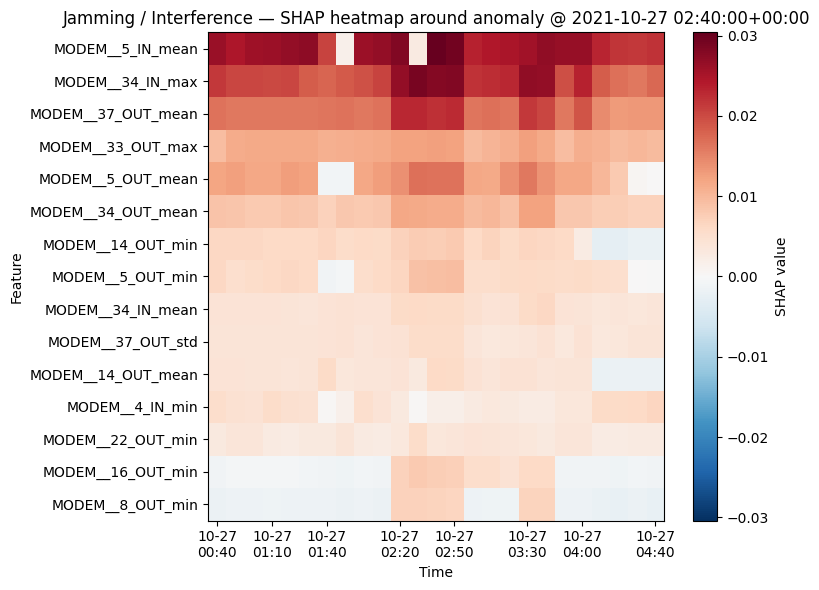

Saved continuous heatmap to: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_jamming/jamming_continuous_heatmap.png


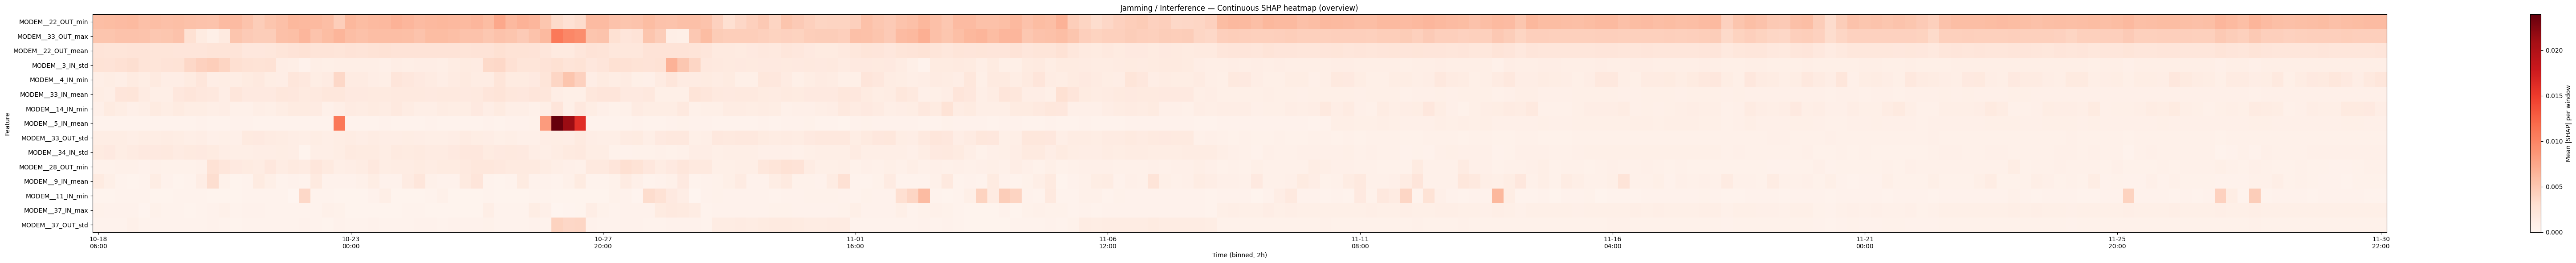

=== SHAP heatmaps for Jamming / Interference done.


In [11]:
# ============================================
# 7. SHAP HEATMAPS
# ============================================

# === JAMMING / INTERFERENCE — SHAP HEATMAPS (EVENT + CONTINUOUS) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = False

# -------------------------------------------------------------------
# 0. Load comm features and prepare directories
# -------------------------------------------------------------------
OUT_JAM = os.path.join(DATA_DIR, "artifacts_jamming")
os.makedirs(OUT_JAM, exist_ok=True)

comm_path = os.path.join(DATA_DIR, "ses_comm_features.csv")
df_comm = pd.read_csv(comm_path)

# Expect a column called "time" as timestamp index
if "time" not in df_comm.columns:
    raise ValueError("Expected a 'time' column in ses_comm_features.csv")

df_comm["time"] = pd.to_datetime(df_comm["time"])
df_comm = df_comm.set_index("time").sort_index()

# Separate features and target (anomaly_score)
target_col = "anomaly_score"
if target_col not in df_comm.columns:
    raise ValueError(f"Expected '{target_col}' in ses_comm_features.csv")

y = df_comm[target_col]

feature_cols = [c for c in df_comm.columns if c not in [target_col, "is_anomaly"]]
X = df_comm[feature_cols]

print("Jamming/Interference: X shape:", X.shape, "| y shape:", y.shape)

# -------------------------------------------------------------------
# 1. Train / retrain surrogate model for anomaly_score
# -------------------------------------------------------------------
# Time-based split: use early part for train, later part for test
n = len(X)
split_idx = int(0.8 * n)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

surrogate = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

surrogate.fit(X_train, y_train)
r2 = surrogate.score(X_test, y_test)
print(f"[Jamming] Surrogate R^2 on hold-out: {r2:.3f}")

# SHAP explainer for surrogate
explainer_jam = shap.TreeExplainer(surrogate)

# -------------------------------------------------------------------
# 2. Helper: compute SHAP window
# -------------------------------------------------------------------
def compute_shap_window_jam(
    explainer,
    X_full: pd.DataFrame,
    t_start: pd.Timestamp,
    t_end: pd.Timestamp,
    max_points: int = 300,
):
    """
    Compute SHAP values for a time window [t_start, t_end] on X_full.
    """
    X_win = X_full.loc[t_start:t_end]
    if X_win.empty:
        raise ValueError("No samples in the requested time window.")

    if len(X_win) > max_points:
        idx = np.linspace(0, len(X_win) - 1, max_points).astype(int)
        X_win = X_win.iloc[idx]

    shap_vals = explainer.shap_values(X_win)
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]

    return X_win, np.array(shap_vals)


# -------------------------------------------------------------------
# 3. Helper: per-event SHAP heatmap
# -------------------------------------------------------------------
def plot_shap_event_heatmap_jam(
    X_win: pd.DataFrame,
    shap_vals: np.ndarray,
    top_n_features: int = 15,
    title: str = None,
    save_path: str = None,
):
    """
    SHAP 'saliency-style' heatmap over time for one anomaly window.
    """
    assert shap_vals.shape[0] == len(X_win)
    feature_names = X_win.columns

    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1]
    if top_n_features is not None:
        order = order[:top_n_features]

    shap_sel = shap_vals[:, order]
    feat_sel = feature_names[order]
    mat = shap_sel.T
    times = X_win.index

    plt.figure(figsize=(max(8, len(times) / 4), max(4, top_n_features * 0.4)))
    vmax = np.max(np.abs(mat))
    im = plt.imshow(
        mat,
        aspect="auto",
        cmap="RdBu_r",
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
    )
    plt.colorbar(im, label="SHAP value")

    plt.yticks(ticks=np.arange(len(feat_sel)), labels=feat_sel)

    n_ticks = min(8, len(times))
    tick_idx = np.linspace(0, len(times) - 1, n_ticks).astype(int)
    tick_labels = [times[i].strftime("%m-%d\n%H:%M") for i in tick_idx]
    plt.xticks(ticks=tick_idx, labels=tick_labels)

    plt.xlabel("Time")
    plt.ylabel("Feature")
    plt.title(title or "Jamming / Interference — SHAP event heatmap")

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print("Saved event heatmap to:", save_path)
    plt.show()


# -------------------------------------------------------------------
# 4. Helper: continuous SHAP heatmap (overview)
# -------------------------------------------------------------------
def plot_shap_continuous_heatmap_jam(
    explainer,
    X_full: pd.DataFrame,
    window_size: str = "2h", # Changed from '2H' to '2h'
    max_windows: int = 200,
    top_n_features: int = 15,
    title: str = None,
    save_path: str = None,
):
    """
    Continuous SHAP heatmap (overview) for Jamming/Interference.
    Each column = time window, each row = feature, colour = mean |SHAP|.
    """
    X_grouped = []
    time_bins = []
    for t_bin, X_bin in X_full.groupby(pd.Grouper(freq=window_size)):
        if X_bin.empty:
            continue
        X_grouped.append(X_bin)
        time_bins.append(t_bin)

    if not X_grouped:
        raise ValueError("No data for SHAP continuous heatmap.")

    if len(X_grouped) > max_windows:
        idx = np.linspace(0, len(X_grouped) - 1, max_windows).astype(int)
        X_grouped = [X_grouped[i] for i in idx]
        time_bins = [time_bins[i] for i in idx]

    feature_names = X_full.columns
    mat_list = []

    for X_bin in X_grouped:
        X_bin_small = X_bin
        if len(X_bin_small) > 300:
            idx = np.linspace(0, len(X_bin_small) - 1, 300).astype(int)
            X_bin_small = X_bin_small.iloc[idx]

        shap_vals_bin = explainer.shap_values(X_bin_small)
        if isinstance(shap_vals_bin, list):
            shap_vals_bin = shap_vals_bin[0]

        mean_abs_bin = np.mean(np.abs(shap_vals_bin), axis=0)
        mat_list.append(mean_abs_bin)

    mat = np.vstack(mat_list).T  # (n_features, n_windows)

    global_mean_abs = np.mean(mat, axis=1)
    order = np.argsort(global_mean_abs)[::-1]
    if top_n_features is not None:
        order = order[:top_n_features]

    mat_sel = mat[order, :]
    feat_sel = feature_names[order]

    plt.figure(figsize=(max(8, len(time_bins) / 3), max(4, top_n_features * 0.4)))
    im = plt.imshow(
        mat_sel,
        aspect="auto",
        cmap="Reds",
        interpolation="nearest",
        vmin=0,
        vmax=np.max(mat_sel),
    )
    plt.colorbar(im, label="Mean |SHAP| per window")

    plt.yticks(ticks=np.arange(len(feat_sel)), labels=feat_sel)

    n_ticks = min(10, len(time_bins))
    tick_idx = np.linspace(0, len(time_bins) - 1, n_ticks).astype(int)
    tick_labels = [time_bins[i].strftime("%m-%d\n%H:%M") for i in tick_idx]
    plt.xticks(ticks=tick_idx, labels=tick_labels)

    plt.xlabel(f"Time (binned, {window_size})")
    plt.ylabel("Feature")
    plt.title(title or "Jamming / Interference — Continuous SHAP heatmap")

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print("Saved continuous heatmap to:", save_path)
    plt.show()


# -------------------------------------------------------------------
# 5. PART A — Per-event SHAP heatmap (strongest anomaly)
# -------------------------------------------------------------------
# Pick the timestamp with the highest anomaly score
top_ts = y.idxmax()
print("Top anomaly timestamp:", top_ts)

pad = pd.Timedelta(hours=2)  # show ±2h around the anomaly
t_start = top_ts - pad
t_end = top_ts + pad
print("Event window:", t_start, "->", t_end)

X_win_jam, shap_vals_jam = compute_shap_window_jam(
    explainer=explainer_jam,
    X_full=X,
    t_start=t_start,
    t_end=t_end,
    max_points=300,
)

plot_shap_event_heatmap_jam(
    X_win_jam,
    shap_vals_jam,
    top_n_features=15,
    title=f"Jamming / Interference — SHAP heatmap around anomaly @ {top_ts}",
    save_path=os.path.join(OUT_JAM, "jamming_event_heatmap.png"),
)

# -------------------------------------------------------------------
# 6. PART B — Continuous SHAP heatmap (overview)
# -------------------------------------------------------------------
plot_shap_continuous_heatmap_jam(
    explainer=explainer_jam,
    X_full=X,
    window_size="2h", # Changed from '2H' to '2h'
    max_windows=200,
    top_n_features=15,
    title="Jamming / Interference — Continuous SHAP heatmap (overview)",
    save_path=os.path.join(OUT_JAM, "jamming_continuous_heatmap.png"),
)

print("=== SHAP heatmaps for Jamming / Interference done.")
